# Applying RNN Classification Model to IMDB Movie Review Dataset

## Summary:
In this notebook we look at how we can use a Recursive Neural Network Model (RNN) in order to classify movie reviews as either positive or negative!

Since this is my first time using pytorch I relied upon a Youtube tutorial (https://youtu.be/KgrdifrlDxg) while I was creating my RNN implementation, but I will be adding in comments to explain the things I learned and I will be altering parameters to see how the model is affected!



In [1]:
#Imports:
#General Imports
import os
import numpy as np 
import pandas as pd 
import time
import random

#visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

#All Imports for Pytorch
import torch
import torch.nn.functional as F
import torchtext
torch.backends.cudnn.deterministic = True

#All Imports for Tensorflow
#import tensorflow as tf
#import tensorflow_hub as hub
#import tensorflow_text as text
#from official.nlp import optimization  # to create AdamW optimizer
#tf.get_logger().setLevel('ERROR')

#Dependencies, Downloads, and other necessary installations
#!conda install spacy
#!pip install wordcloud

## Part 1: Downloading IMDB Dataset and EDA

In [2]:
#Grabbing IMDB dataset from an online 
!wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
!gunzip -f movie_data.csv.gz 

--2022-01-26 05:08:18--  https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz [following]
--2022-01-26 05:08:19--  https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘movie_data.csv.gz’

movie_data.csv.gz   100%[===================>]  25.29M  13.8MB/s  

In [3]:
df = pd.read_csv('movie_data.csv')
print(df)
df.head()

                                                  review  sentiment
0      In 1974, the teenager Martha Moxley (Maggie Gr...          1
1      OK... so... I really like Kris Kristofferson a...          0
2      ***SPOILER*** Do not read this, if you think a...          0
3      hi for all the people who have seen this wonde...          1
4      I recently bought the DVD, forgetting just how...          0
...                                                  ...        ...
49995  OK, lets start with the best. the building. al...          0
49996  The British 'heritage film' industry is out of...          0
49997  I don't even know where to begin on this one. ...          0
49998  Richard Tyler is a little boy who is scared of...          0
49999  I waited long to watch this movie. Also becaus...          1

[50000 rows x 2 columns]


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


### It is important that the number of positive sentiment examples is at least roughly equivalent to the number of negative sentiment examples in the dataset.  This is because if there were far more positive examples then some naive models may just always guess positive in order to easily get an accuracy above 50%. 

### In the bar graph below we can confirm that there are 25000 positive reviews and 25000 negative reviews meaning that our model will actually have to "learn" something about the reviews to get above a 50% accuracy!

           review
sentiment        
0           25000
1           25000


<AxesSubplot:xlabel='sentiment'>

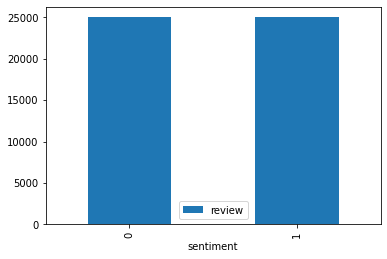

In [4]:
# The distribution of sentiments
print(df.groupby('sentiment').count())
df.groupby('sentiment').count().plot(kind='bar')

Text(0, 0.5, 'Length of Review (Characters)')

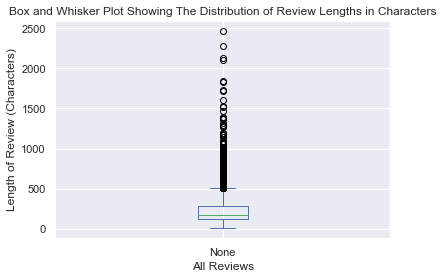

In [27]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in df['review']])

# The distribution of review text lengths
review_len.plot(kind='box')
plt.title("Box and Whisker Plot Showing The Distribution of Review Lengths in Characters")
plt.xlabel("All Reviews")
plt.ylabel("Length of Review (Characters)")

### In the 2 figures below I split the reviews up into the positive and negative reviews. I then look at the distributions for the review lengths. 

### I was surprised when I found that the mean length for positive reviews was 232.85 characters which was larger than the mean length for negative reviews 229.46 words.  I had thought that negative reviews in general might be longer because people might be more likely to "rant" in negative reviews compared to being "concise" in positive ones. 

### The distributions of length for positive and negative reviews seem to be very similar so I suppose our neural network will have to find other ways to distinguish between types of reviews!

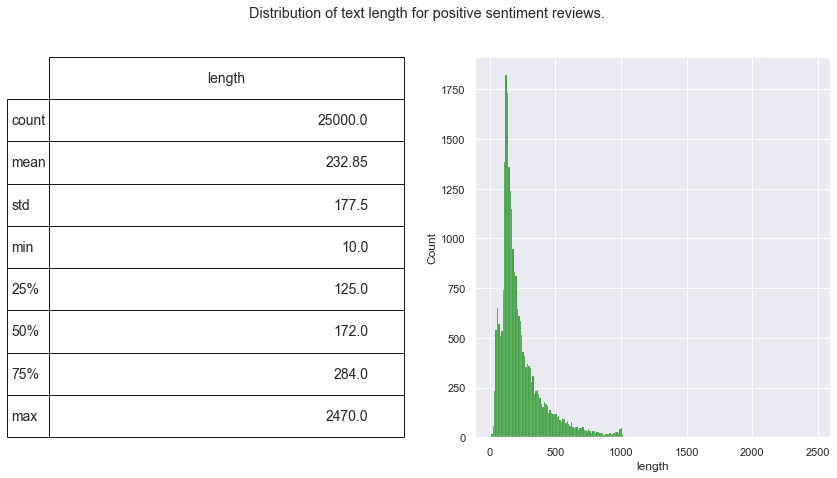

In [32]:
#BELOW I USE SEABORN TO MAKE NICE LOOKING FIGURES FOR BOTH POSITIVE AND NEGATIVE SENTIMENT REVIEWS
fig = plt.figure(figsize=(14,7))
df['length'] = df.review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==1]['length'], ax=ax1,color='green')    #GRABBING ALL POSITIVE REVIEWS FOR HISTOGRAM
describe = df.length[df.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.')

plt.show()

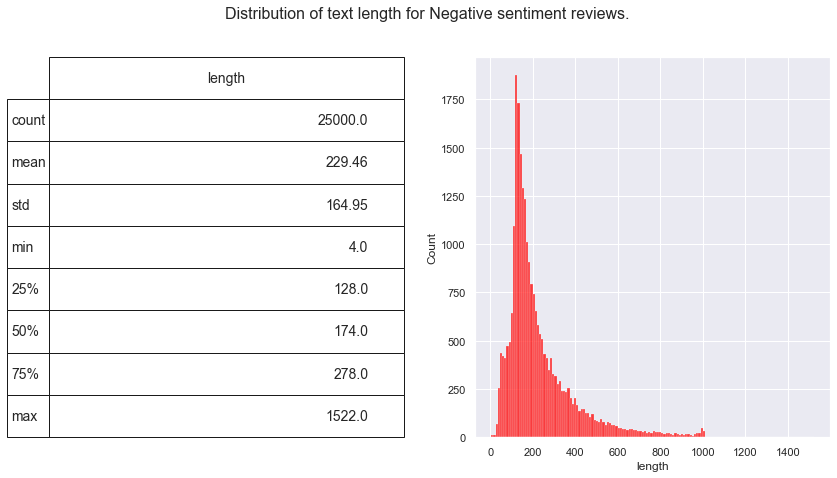

In [8]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df[df['sentiment']==0]['length'], ax=ax1,color='red') #GRABBING ALL NEGATIVE REVIEWS FOR HISTOGRAM
describe = df.length[df.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.')

plt.show()

### Below I looked up how to make word clouds to visualize common words in both the positive and negative review datasets.  The larger a word is the more often it comes up in the reviews.  Just by generally looking at both of these word clouds you can generally see good words like "well", "great", "good" and "love" in the first word cloud for all the positive reviews.  Likewise just by generally looking at the negative word cloud your eyes are more drawn towards words like "bad", "waste", and "never".

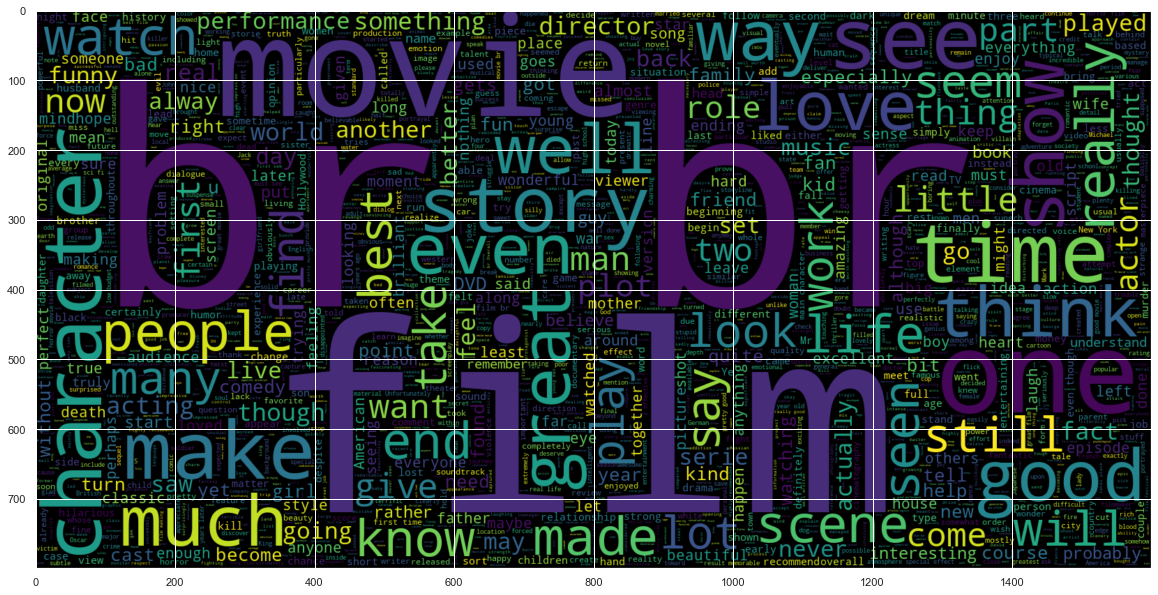

In [9]:
from wordcloud import WordCloud
#CREATING WORDCLOUD FOR POSITIVE REVIEWS!!
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

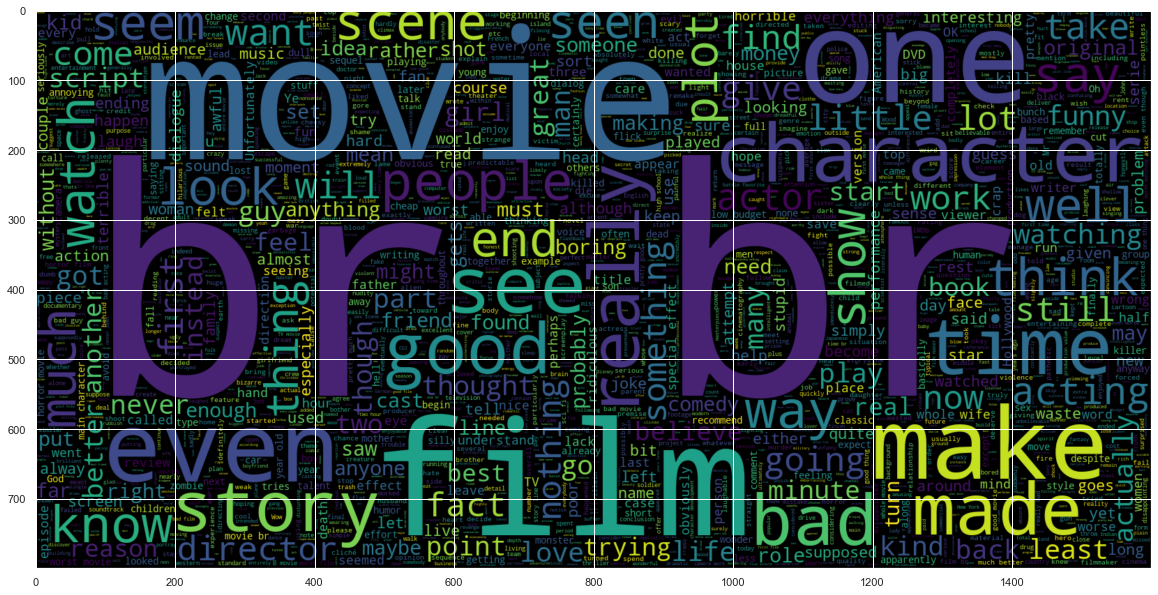

In [10]:
#CREATING WORDCLOUD FOR NEGATIVE REVIEWS!!
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

## Part 2: Building RNN Model

In [11]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 8
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 16        #128  USING THESE DIMENSIONS MAKES MODEL FAR TOO LARGE FOR ME TO FEASIBLY TRAIN
HIDDEN_DIM =  24         #256
NUM_CLASSES = 2

In [12]:
### Defining the feature processing

TEXT = torchtext.legacy.data.Field(
    tokenize='spacy', # default splits on whitespace
    tokenizer_language='en_core_web_sm'
)

### Defining the label processing

LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

In [13]:
fields = [('TEXT_COLUMN_NAME', TEXT), ('LABEL_COLUMN_NAME', LABEL)]

dataset = torchtext.legacy.data.TabularDataset(
    path='movie_data.csv', format='csv',
    skip_header=True, fields=fields)

In [14]:
torch.manual_seed(RANDOM_SEED)
train_data, test_data = dataset.split(
    split_ratio=[0.8, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 40000
Num Test: 10000


In [15]:
train_data, valid_data = train_data.split(
    split_ratio=[0.85, 0.15],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Validation: {len(valid_data)}')
print(vars(train_data.examples[0]))

Num Train: 34000
Num Validation: 6000
{'TEXT_COLUMN_NAME': ['For', 'some', 'unknown', 'reason', ',', '7', 'years', 'ago', ',', 'I', 'watched', 'this', 'movie', 'with', 'my', 'mother', 'and', 'sister', '.', 'I', 'do', "n't", 'think', 'I', "'ve", 'ever', 'laughed', 'as', 'hard', 'with', 'them', 'before', '.', 'This', 'movie', 'was', 'sooooo', 'bad', '.', 'How', 'sequels', 'were', 'produced', 'is', 'beyond', 'me', '.', 'Its', 'been', 'awhile', 'since', 'I', 'last', 'saw', 'this', '"', 'movie', '"', ',', 'but', 'the', 'one', 'impression', 'that', 'it', 'has', 'stuck', 'with', 'me', 'over', 'the', 'years', 'has', 'been', ',', '"', 'They', 'must', 'have', 'found', 'the', 'script', 'in', 'a', 'dumpster', 'in', 'the', 'backlot', 'of', 'a', 'cheap', 'movie', 'studio', ',', 'made', 'into', 'a', '"', 'movie', '"', ',', 'and', 'decided', 'that', 'it', 'did', "n't", 'suck', 'enough', ',', 'and', 'made', 'it', 'worse', '.', 'I', "'m", 'pretty', 'sure', 'that', 'they', 'spent', 'all', 'the', 'budget'

In [16]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')
print(TEXT.vocab.freqs.most_common(20))
print(TEXT.vocab.itos[:10]) # itos = integer-to-string
print(LABEL.vocab.stoi)
LABEL.vocab.freqs

Vocabulary size: 20002
Number of classes: 2
[('the', 391539), (',', 370979), ('.', 319449), ('and', 210723), ('a', 210397), ('of', 194700), ('to', 180225), ('is', 145689), ('in', 118828), ('I', 105650), ('it', 103414), ('that', 93700), ('"', 86160), ("'s", 83067), ('this', 81424), ('-', 70840), ('/><br', 68865), ('was', 67523), ('as', 57974), ('with', 57558)]
['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
defaultdict(None, {'1': 0, '0': 1})


Counter({'0': 16981, '1': 17019})

In [17]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
         batch_size=BATCH_SIZE,
         sort_within_batch=False,
         sort_key=lambda x: len(x.TEXT_COLUMN_NAME),
         device=DEVICE
    )

In [18]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nValid:')
for batch in valid_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break
    
print('\nTest:')
for batch in test_loader:
    print(f'Text matrix size: {batch.TEXT_COLUMN_NAME.size()}')
    print(f'Target vector size: {batch.LABEL_COLUMN_NAME.size()}')
    break

Train
Text matrix size: torch.Size([1136, 128])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([55, 128])
Target vector size: torch.Size([128])

Test:
Text matrix size: torch.Size([52, 128])
Target vector size: torch.Size([128])


In [19]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        #self.rnn = torch.nn.RNN(embedding_dim,
        #                        hidden_dim,
        #                        nonlinearity='relu')
        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)        
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        

    def forward(self, text):
        # text dim: [sentence length, batch size]
        
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        
        output = self.fc(hidden)
        return output

In [20]:
torch.manual_seed(RANDOM_SEED)
model = RNN(input_dim=len(TEXT.vocab),
            embedding_dim=EMBEDDING_DIM,
            hidden_dim=HIDDEN_DIM,
            output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [21]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

## Part 3: RNN Training and Loading Weights from Optimal Hyperparameters

## Note that the first time I train the model below, the model does very poorly with classifying reviews!  In fact it gets only a meager 49.89% on the test set so it is worse than guessing!  I believe that this is happening because in this training case I made my neural network very small so not much information could be encoded (this allowed it to train faster though).  Also I made the number of epochs very low so it probably didn't converge at all. 

## Note that in my other jupyter notebook I address these issues and find a model architecture and hyperparameters that allow it to learn during training!  I save this model and then load it further down.

In [22]:
start_time = time.time()
NUM_EPOCHS = 3
BATCH_SIZE = 24
EMBEDDING_DIM = 8        #128
HIDDEN_DIM =  16         #256

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text = batch_data.TEXT_COLUMN_NAME.to(DEVICE)
        labels = batch_data.LABEL_COLUMN_NAME.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits = model(text)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        
        loss.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
               f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
               f'Loss: {loss:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_accuracy(model, test_loader, DEVICE):.2f}%')

Epoch: 001/003 | Batch 000/266 | Loss: 0.6969
Epoch: 001/003 | Batch 001/266 | Loss: 0.6941
Epoch: 001/003 | Batch 002/266 | Loss: 0.6930
Epoch: 001/003 | Batch 003/266 | Loss: 0.6903
Epoch: 001/003 | Batch 004/266 | Loss: 0.6955
Epoch: 001/003 | Batch 005/266 | Loss: 0.6904
Epoch: 001/003 | Batch 006/266 | Loss: 0.7008
Epoch: 001/003 | Batch 007/266 | Loss: 0.7024
Epoch: 001/003 | Batch 008/266 | Loss: 0.6965
Epoch: 001/003 | Batch 009/266 | Loss: 0.6937
Epoch: 001/003 | Batch 010/266 | Loss: 0.6931
Epoch: 001/003 | Batch 011/266 | Loss: 0.6943
Epoch: 001/003 | Batch 012/266 | Loss: 0.6871
Epoch: 001/003 | Batch 013/266 | Loss: 0.6897
Epoch: 001/003 | Batch 014/266 | Loss: 0.6835
Epoch: 001/003 | Batch 015/266 | Loss: 0.7150
Epoch: 001/003 | Batch 016/266 | Loss: 0.7032
Epoch: 001/003 | Batch 017/266 | Loss: 0.6989
Epoch: 001/003 | Batch 018/266 | Loss: 0.6953
Epoch: 001/003 | Batch 019/266 | Loss: 0.6915
Epoch: 001/003 | Batch 020/266 | Loss: 0.6981
Epoch: 001/003 | Batch 021/266 | L

Epoch: 001/003 | Batch 179/266 | Loss: 0.6888
Epoch: 001/003 | Batch 180/266 | Loss: 0.6947
Epoch: 001/003 | Batch 181/266 | Loss: 0.6955
Epoch: 001/003 | Batch 182/266 | Loss: 0.6974
Epoch: 001/003 | Batch 183/266 | Loss: 0.6928
Epoch: 001/003 | Batch 184/266 | Loss: 0.6972
Epoch: 001/003 | Batch 185/266 | Loss: 0.6950
Epoch: 001/003 | Batch 186/266 | Loss: 0.6931
Epoch: 001/003 | Batch 187/266 | Loss: 0.6922
Epoch: 001/003 | Batch 188/266 | Loss: 0.6925
Epoch: 001/003 | Batch 189/266 | Loss: 0.6926
Epoch: 001/003 | Batch 190/266 | Loss: 0.6931
Epoch: 001/003 | Batch 191/266 | Loss: 0.6940
Epoch: 001/003 | Batch 192/266 | Loss: 0.6939
Epoch: 001/003 | Batch 193/266 | Loss: 0.6932
Epoch: 001/003 | Batch 194/266 | Loss: 0.6927
Epoch: 001/003 | Batch 195/266 | Loss: 0.6936
Epoch: 001/003 | Batch 196/266 | Loss: 0.6915
Epoch: 001/003 | Batch 197/266 | Loss: 0.6919
Epoch: 001/003 | Batch 198/266 | Loss: 0.6899
Epoch: 001/003 | Batch 199/266 | Loss: 0.6942
Epoch: 001/003 | Batch 200/266 | L

Epoch: 002/003 | Batch 090/266 | Loss: 0.6957
Epoch: 002/003 | Batch 091/266 | Loss: 0.6915
Epoch: 002/003 | Batch 092/266 | Loss: 0.6942
Epoch: 002/003 | Batch 093/266 | Loss: 0.6943
Epoch: 002/003 | Batch 094/266 | Loss: 0.6926
Epoch: 002/003 | Batch 095/266 | Loss: 0.6920
Epoch: 002/003 | Batch 096/266 | Loss: 0.6928
Epoch: 002/003 | Batch 097/266 | Loss: 0.6935
Epoch: 002/003 | Batch 098/266 | Loss: 0.6938
Epoch: 002/003 | Batch 099/266 | Loss: 0.6926
Epoch: 002/003 | Batch 100/266 | Loss: 0.6939
Epoch: 002/003 | Batch 101/266 | Loss: 0.6924
Epoch: 002/003 | Batch 102/266 | Loss: 0.6927
Epoch: 002/003 | Batch 103/266 | Loss: 0.6926
Epoch: 002/003 | Batch 104/266 | Loss: 0.6929
Epoch: 002/003 | Batch 105/266 | Loss: 0.6939
Epoch: 002/003 | Batch 106/266 | Loss: 0.6933
Epoch: 002/003 | Batch 107/266 | Loss: 0.6938
Epoch: 002/003 | Batch 108/266 | Loss: 0.6929
Epoch: 002/003 | Batch 109/266 | Loss: 0.6927
Epoch: 002/003 | Batch 110/266 | Loss: 0.6928
Epoch: 002/003 | Batch 111/266 | L

Epoch: 003/003 | Batch 001/266 | Loss: 0.6920
Epoch: 003/003 | Batch 002/266 | Loss: 0.6909
Epoch: 003/003 | Batch 003/266 | Loss: 0.6945
Epoch: 003/003 | Batch 004/266 | Loss: 0.6946
Epoch: 003/003 | Batch 005/266 | Loss: 0.6932
Epoch: 003/003 | Batch 006/266 | Loss: 0.6923
Epoch: 003/003 | Batch 007/266 | Loss: 0.6953
Epoch: 003/003 | Batch 008/266 | Loss: 0.6937
Epoch: 003/003 | Batch 009/266 | Loss: 0.6936
Epoch: 003/003 | Batch 010/266 | Loss: 0.6942
Epoch: 003/003 | Batch 011/266 | Loss: 0.6933
Epoch: 003/003 | Batch 012/266 | Loss: 0.6936
Epoch: 003/003 | Batch 013/266 | Loss: 0.6935
Epoch: 003/003 | Batch 014/266 | Loss: 0.6918
Epoch: 003/003 | Batch 015/266 | Loss: 0.6930
Epoch: 003/003 | Batch 016/266 | Loss: 0.6938
Epoch: 003/003 | Batch 017/266 | Loss: 0.6935
Epoch: 003/003 | Batch 018/266 | Loss: 0.6928
Epoch: 003/003 | Batch 019/266 | Loss: 0.6935
Epoch: 003/003 | Batch 020/266 | Loss: 0.6922
Epoch: 003/003 | Batch 021/266 | Loss: 0.6926
Epoch: 003/003 | Batch 022/266 | L

Epoch: 003/003 | Batch 180/266 | Loss: 0.6934
Epoch: 003/003 | Batch 181/266 | Loss: 0.6917
Epoch: 003/003 | Batch 182/266 | Loss: 0.6923
Epoch: 003/003 | Batch 183/266 | Loss: 0.6926
Epoch: 003/003 | Batch 184/266 | Loss: 0.6947
Epoch: 003/003 | Batch 185/266 | Loss: 0.6927
Epoch: 003/003 | Batch 186/266 | Loss: 0.6961
Epoch: 003/003 | Batch 187/266 | Loss: 0.6939
Epoch: 003/003 | Batch 188/266 | Loss: 0.6924
Epoch: 003/003 | Batch 189/266 | Loss: 0.6930
Epoch: 003/003 | Batch 190/266 | Loss: 0.6936
Epoch: 003/003 | Batch 191/266 | Loss: 0.6938
Epoch: 003/003 | Batch 192/266 | Loss: 0.6943
Epoch: 003/003 | Batch 193/266 | Loss: 0.6918
Epoch: 003/003 | Batch 194/266 | Loss: 0.6919
Epoch: 003/003 | Batch 195/266 | Loss: 0.6946
Epoch: 003/003 | Batch 196/266 | Loss: 0.6925
Epoch: 003/003 | Batch 197/266 | Loss: 0.6939
Epoch: 003/003 | Batch 198/266 | Loss: 0.6965
Epoch: 003/003 | Batch 199/266 | Loss: 0.6929
Epoch: 003/003 | Batch 200/266 | Loss: 0.6944
Epoch: 003/003 | Batch 201/266 | L

## Below I load in the weights from the best RNN model I was able to train locally! (I was testing different hyperparameter combinations in my other notebook "JacksonCurryrnnHyperParameterTuning.ipynb"). 

## Thus I can just load in the weights I saved at the end of that notebook and don't have to retrain the model here which is nice!

In [23]:
model.load_state_dict(torch.load("./bestRNNweights"))
#model.eval()

<All keys matched successfully>

## Part 4: Testing Final RNN Model on Personally Written Reviews

### Below we can see a function where I am able to predict the probability of either positive or negative sentiment for any given string input!  The first string we can see it predicts is a positive review with 85% confidence.

### Then the second review it predicts is a bad review with 90% confidence.  Finally I add a couple extra bad words to the end of my custom string and this allows the model to be 99% confident that the final string is a negative review!

In [24]:
import spacy


nlp = spacy.blank("en")

def predict_sentiment(model, sentence):

    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.nn.functional.softmax(model(tensor), dim=1)
    return prediction[0][0].item()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")

Probability positive:


0.8576191663742065

In [25]:
print('Probability negative:')
1-predict_sentiment(model, "I really hate this movie. It is bad.")

Probability negative:


0.9056250900030136

In [26]:
print('Probability negative:')
1-predict_sentiment(model, "I really hate this movie. It is really bad and sucks! Bad Bad Bad! The worst ever!!! So Bad.")

Probability negative:


0.9992182682617567

In [1]:
print(model)

NameError: name 'model' is not defined

In [2]:
print(TEXT)

NameError: name 'TEXT' is not defined